In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_name = self.data.iloc[index, 0]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        
        label = self.data.iloc[index, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Hyper-parameters
num_epochs = 15
batch_size = 5
learning_rate = 0.001

In [6]:
csv_file = "train_truth.csv"
image_directory = "music_train"
test_data_path = 'music_test'

In [7]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])


In [8]:
# Create an instance of the custom dataset
train_dataset = CustomDataset(csv_file=csv_file, root_dir=image_directory, transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


# Create a DataLoader to handle batching and shuffling of the data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(16, 32, 5)
        
        self.fc1 = nn.Linear(batch_size*32*5, 120)
        self.fc2 = nn.Linear(120, 88)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, batch_size*32*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [10]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
import os
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_dataset)
        val_acc = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
         f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
print("Finished Training")

Epoch 1/15: Train Loss: 3.5662, Train Acc: 0.0918, Val Loss: 2.5198, Val Acc: 0.2175
Epoch 2/15: Train Loss: 1.7124, Train Acc: 0.4041, Val Loss: 1.1983, Val Acc: 0.5439
Epoch 3/15: Train Loss: 0.8296, Train Acc: 0.7001, Val Loss: 0.6628, Val Acc: 0.7789
Epoch 4/15: Train Loss: 0.4451, Train Acc: 0.8516, Val Loss: 0.2782, Val Acc: 0.9263
Epoch 5/15: Train Loss: 0.2724, Train Acc: 0.9094, Val Loss: 0.1710, Val Acc: 0.9404
Epoch 6/15: Train Loss: 0.1811, Train Acc: 0.9449, Val Loss: 0.2613, Val Acc: 0.8947
Epoch 7/15: Train Loss: 0.1650, Train Acc: 0.9520, Val Loss: 0.1524, Val Acc: 0.9544
Epoch 8/15: Train Loss: 0.1297, Train Acc: 0.9594, Val Loss: 0.3150, Val Acc: 0.9509
Epoch 9/15: Train Loss: 0.1013, Train Acc: 0.9723, Val Loss: 0.0873, Val Acc: 0.9719
Epoch 10/15: Train Loss: 0.1313, Train Acc: 0.9590, Val Loss: 0.0439, Val Acc: 0.9895
Epoch 11/15: Train Loss: 0.0585, Train Acc: 0.9801, Val Loss: 0.0461, Val Acc: 0.9825
Epoch 12/15: Train Loss: 0.0415, Train Acc: 0.9902, Val Loss: 0

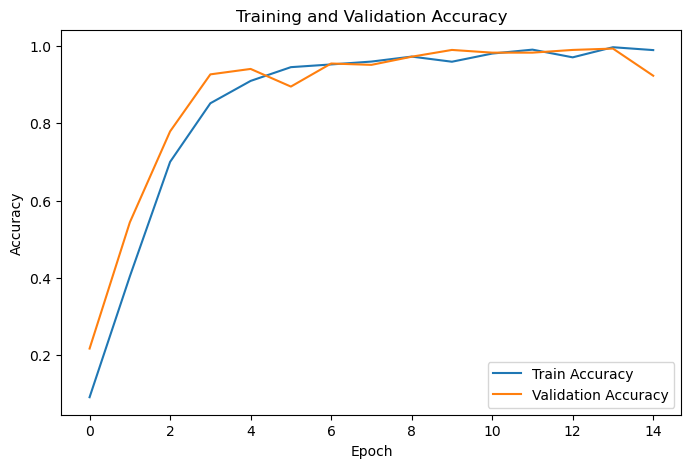

In [14]:
# Plot the training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

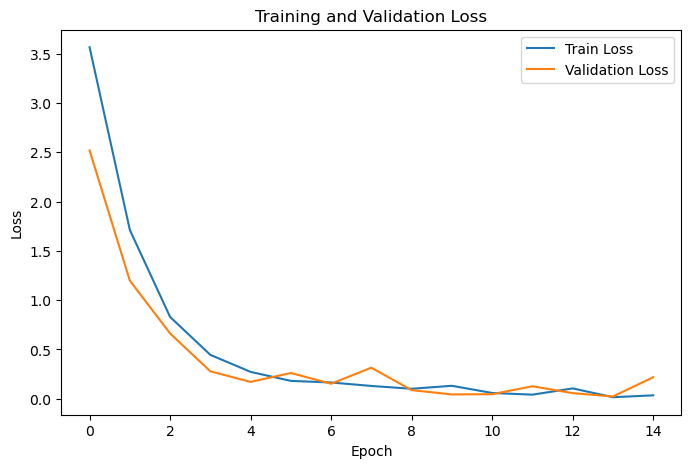

In [15]:
# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [16]:
import torchvision.transforms as transforms
from PIL import Image
import csv

with torch.no_grad():

    # Apply the transformation pipeline
    transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])
    
    folder_path = 'music_test'
    csv_file = 'output.csv'

    # Get the list of filenames in the folder
    file_list = os.listdir(folder_path)

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['filename', 'category'])

        # Write each filename to a new row in the CSV file
        for filename in file_list:
            image_path = folder_path+'/'+filename
            # Open the image
            image = Image.open(image_path).convert("RGB")
            processed_image = transform(image)
            processed_image = processed_image.unsqueeze(0)
            output = model(processed_image)
            predicted_index = np.argmax(output, axis=1)
            value = predicted_index.item()
            
            writer.writerow([filename, value])

    print(f"File list saved to {csv_file}")


File list saved to output.csv


In [17]:
# Save the model
torch.save(model.state_dict(), 'model2.pth')

In [ ]:
# conv1 = nn.Conv2d(4, 6, 5)
# pool = nn.MaxPool2d(2, 2)
# conv2 = nn.Conv2d(6, 16, 5)
# print(images.shape) #(batch_size, color_channel, width, height)
# x = conv1(images)
# print(x.shape)
# x = pool(x)
# print(x.shape)
# x = conv2(x)
# print(x.shape)
# x = pool(x)
# print(x.shape)